# Face Validity

## 1. Noisy Hopfiled  Networks reproduce dynamics of th resting state

## 2. Task-activity maps differently to the Hopfield embeddings than rest
    - energy
    - attractor
    - location/trajectory

## 3. Hopfield-embeddings explain taks-activations better than resting state by itself


In [322]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from nilearn import plotting
from sklearn.preprocessing import StandardScaler
from connattractor import network, analysis
from scipy import interpolate
%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
connfile = '../data_in/connectome_partial_correlation.csv'

mtx = pd.read_csv(connfile)
mtx = mtx.drop("Unnamed: 0", axis='columns')
mtx = mtx.drop("GlobSig", axis="columns")
mtx = mtx.drop(0, axis="index")

## Hopfield embeddings and resting state data
First look at the speed of state transitions, it's adjustable with the noise_coef in the simulations

100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


(0.0, 12.0)

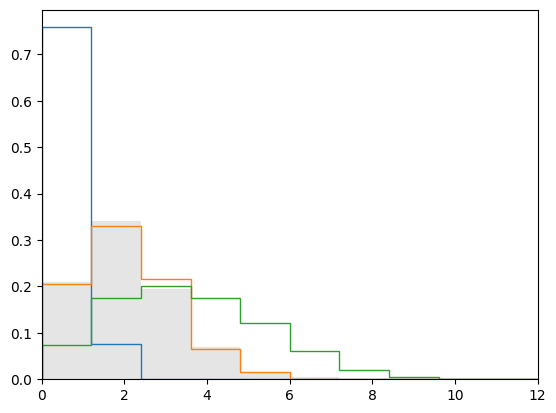

In [52]:
simresults = analysis.simulate_activations(mtx.values, noise_coef=0.5, num_iter=1000, beta=0.04)
hopfield_embedding = analysis.create_embeddings(simresults, attractor_sample=10)


# load data
from glob import glob
import os
all_ts = []
root_dir = '../data_in/ex_timeseries/'

norms_emp = []
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    
    activations = StandardScaler().fit_transform(ts.reshape(1,-1).T).T
    embedded = hopfield_embedding.embedding_model.transform(ts)
    # no scrubbing to preserve continuity
    deltas = embedded[1:, :] - embedded[:-1, :]
    norms_emp.append(np.sqrt(deltas[:,0]**2 + deltas[:,1]**2))

plt.hist(np.array(norms_emp).flatten(), bins=10, range=(0, 12), histtype='bar', alpha=0.1, density=True, color='black')

for step in [1, 2, 3, 4]:
    simresults = analysis.simulate_activations(mtx.values, noise_coef=noise, num_iter=1000, beta=0.04)
    hopfield_embedding = analysis.create_embeddings(simresults, attractor_sample=10)
    # calculate norms
    activations = StandardScaler().fit_transform(simresults.states.T).T
    embedded = hopfield_embedding.embedding_model.transform(simresults.states)
    deltas = embedded[step:, :] - embedded[:-step, :]
    norms_sim = np.sqrt(deltas[:,0]**2 + deltas[:,1]**2)
    plt.hist(norms_sim, bins=10, range=(0, 12), histtype='step', density=True)
plt.gca().set_xlim((0, 12))


## let's look at the ditribution of the data on the 2D Hopfiled-projection

In [57]:
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(root_dir + 'FD_' + filename + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


In [248]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in [0.33, 0.35, 0.37, 0.39]:
    simresults_all[noise] = analysis.simulate_activations(mtx.values, noise_coef=noise, num_iter=100000, beta=0.04)
    hopfield_embeddings_all[noise] = analysis.create_embeddings(simresults, attractor_sample=1000)

100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s]


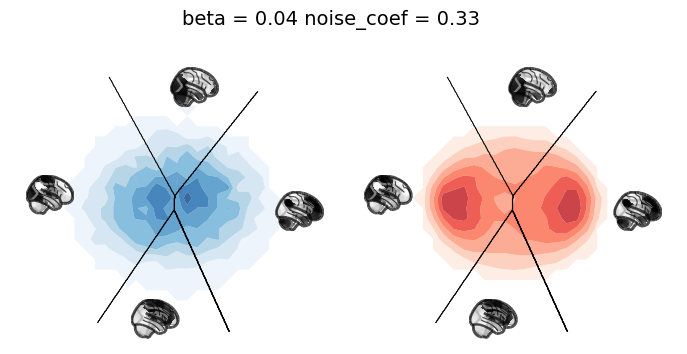

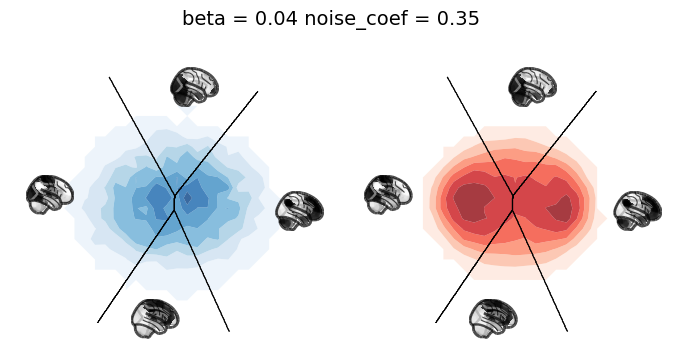

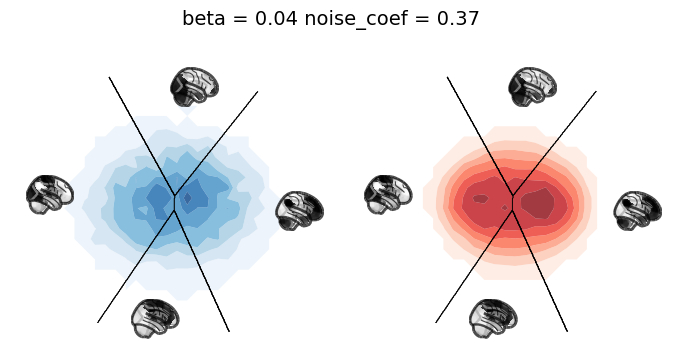

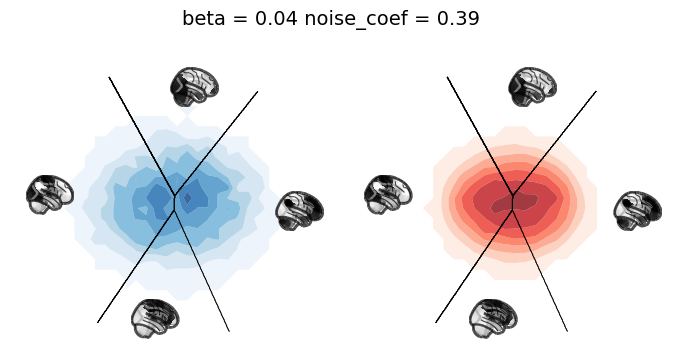

In [256]:
for i in simresults_all.keys():

    fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(8, 4))
    fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
    hopfield_embeddings_all[i].plot(all_ts, plot_type='contourf', ax=ax[0],
                             density_bins=30, density_sigma=0, levels=6, alpha=0.8, cmap='Blues',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[0].set_yticks([])
    ax[0].grid(False)

    hopfield_embeddings_all[i].plot(simresults_all[i].states, plot_type='contourf', ax=ax[1],
                             density_bins=30, density_sigma=0, levels=6, alpha=0.8, cmap='Reds',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[1].set_yticks([])
    ax[1].grid(False)
    plt.savefig('../data_out/fig/emp_vs_generated_beta_' + str(i) + '.pdf')
    plt.show()


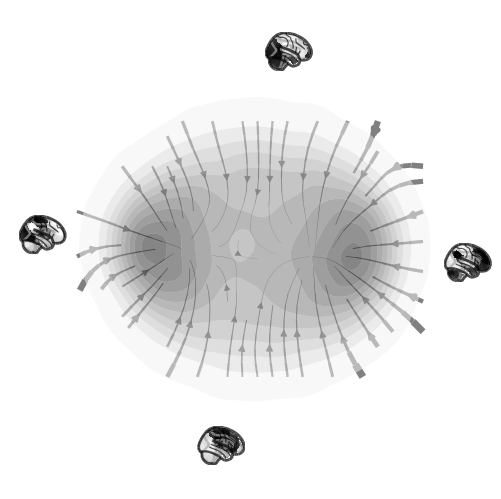

In [277]:

noise = 0.33
ax = hopfield_embeddings_all[noise].plot(simresults_all[noise].states, plot_type='contourf',
                             density_bins=1000, density_sigma=20, levels=12, alpha=0.5, cmap='gray_r',
                        attractor_plot_type='scatter',
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

ax = hopfield_embeddings_all[noise].plot(simresults_all[noise].states, plot_type='stream', density=1, bins=12, linewidth=8,
                             ax=ax,
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

## Reconstruction of the connectome

In [327]:
pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t')

,index,labels,modules
0,9,CER6_p,CER
1,108,CER7ab,CER
2,121,R_CERCR2_p,CER
3,14,CER9_v,CER
4,97,CER6_a,CER
...,...,...,...
117,107,PVISnet_vm,VISnet
118,19,MVISnet_ad,VISnet
119,101,VVISnet_l,VISnet
120,43,LVISnet_DP,VISnet


In [328]:
from nilearn import plotting

def plot_matrix(mat, **kwargs):
    
    atlas_labels = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t')
    

    plotting.plot_matrix(mat, labels=atlas_labels.labels.values, auto_fit=True, norm=norm,
                         cmap=ListedColormap(sns.diverging_palette(220, 15, sep=1, n=31)), **kwargs)

    modules = atlas_labels.modules.values
    
    prev=""
    idx=0
    for i in range(len(labels)):
        if modules[i]!=prev:
            plt.plot([-5, len(labels) + 0.5], [i-0.5, i-0.5], linewidth=1, color='gray')
            plt.plot([i - 0.5, i - 0.5], [-5, len(labels) + 0.5], linewidth=1, color='gray')

            idx=idx+1
            prev=modules[i]

In [329]:
from nilearn.connectome import ConnectivityMeasure
plot_matrix(mtx)
plt.savefig('../data_out/fig/connectome_empirical.pdf')

NameError: name 'mat' is not defined

100%|██████████| 7200/7200 [00:02<00:00, 2500.08it/s]


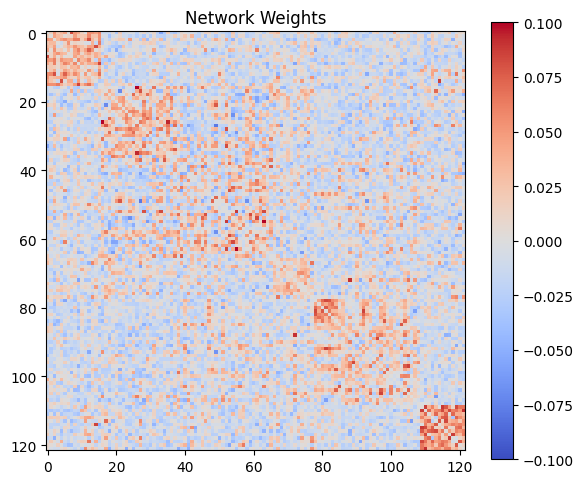

In [324]:
sim = analysis.simulate_activations(mtx.values, noise_coef=noise, num_iter=7200, beta=0.04)
correlation_measure = ConnectivityMeasure(kind="partial correlation")
reconstructed_matrix = correlation_measure.fit_transform([sim.states])[0]
network.Hopfield(reconstructed_matrix, scale=False).plot_weights(vmin=-0.1, vmax=0.1)
plt.savefig('../data_out/fig/connectome_reconstructed.pdf')

# Hopfiled embedding of task-based timeseries
- energy
- attractor
- embedding of task vs. rest

## Hopfield embeddings vs. various activation maps

../data_in/maps/visual_association-test_z_FDR_0.01.nii.gz
../data_in/maps/reward_association-test_z_FDR_0.01.nii.gz
../data_in/maps/semantic memory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/sentences_association-test_z_FDR_0.01.nii.gz
../data_in/maps/auditory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/sensory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/language_association-test_z_FDR_0.01.nii.gz
../data_in/maps/motor_association-test_z_FDR_0.01.nii.gz
../data_in/maps/autobiographical_association-test_z_FDR_0.01.nii.gz
../data_in/maps/theory mind_association-test_z_FDR_0.01.nii.gz
../data_in/maps/self referential_association-test_z_FDR_0.01.nii.gz
../data_in/maps/pain_association-test_z_FDR_0.01.nii.gz
../data_in/maps/default mode_association-test_z_FDR_0.01.nii.gz
../data_in/maps/decision_association-test_z_FDR_0.01.nii.gz
../data_in/maps/working memory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/face_association-test_z_FDR_0.01.nii.gz


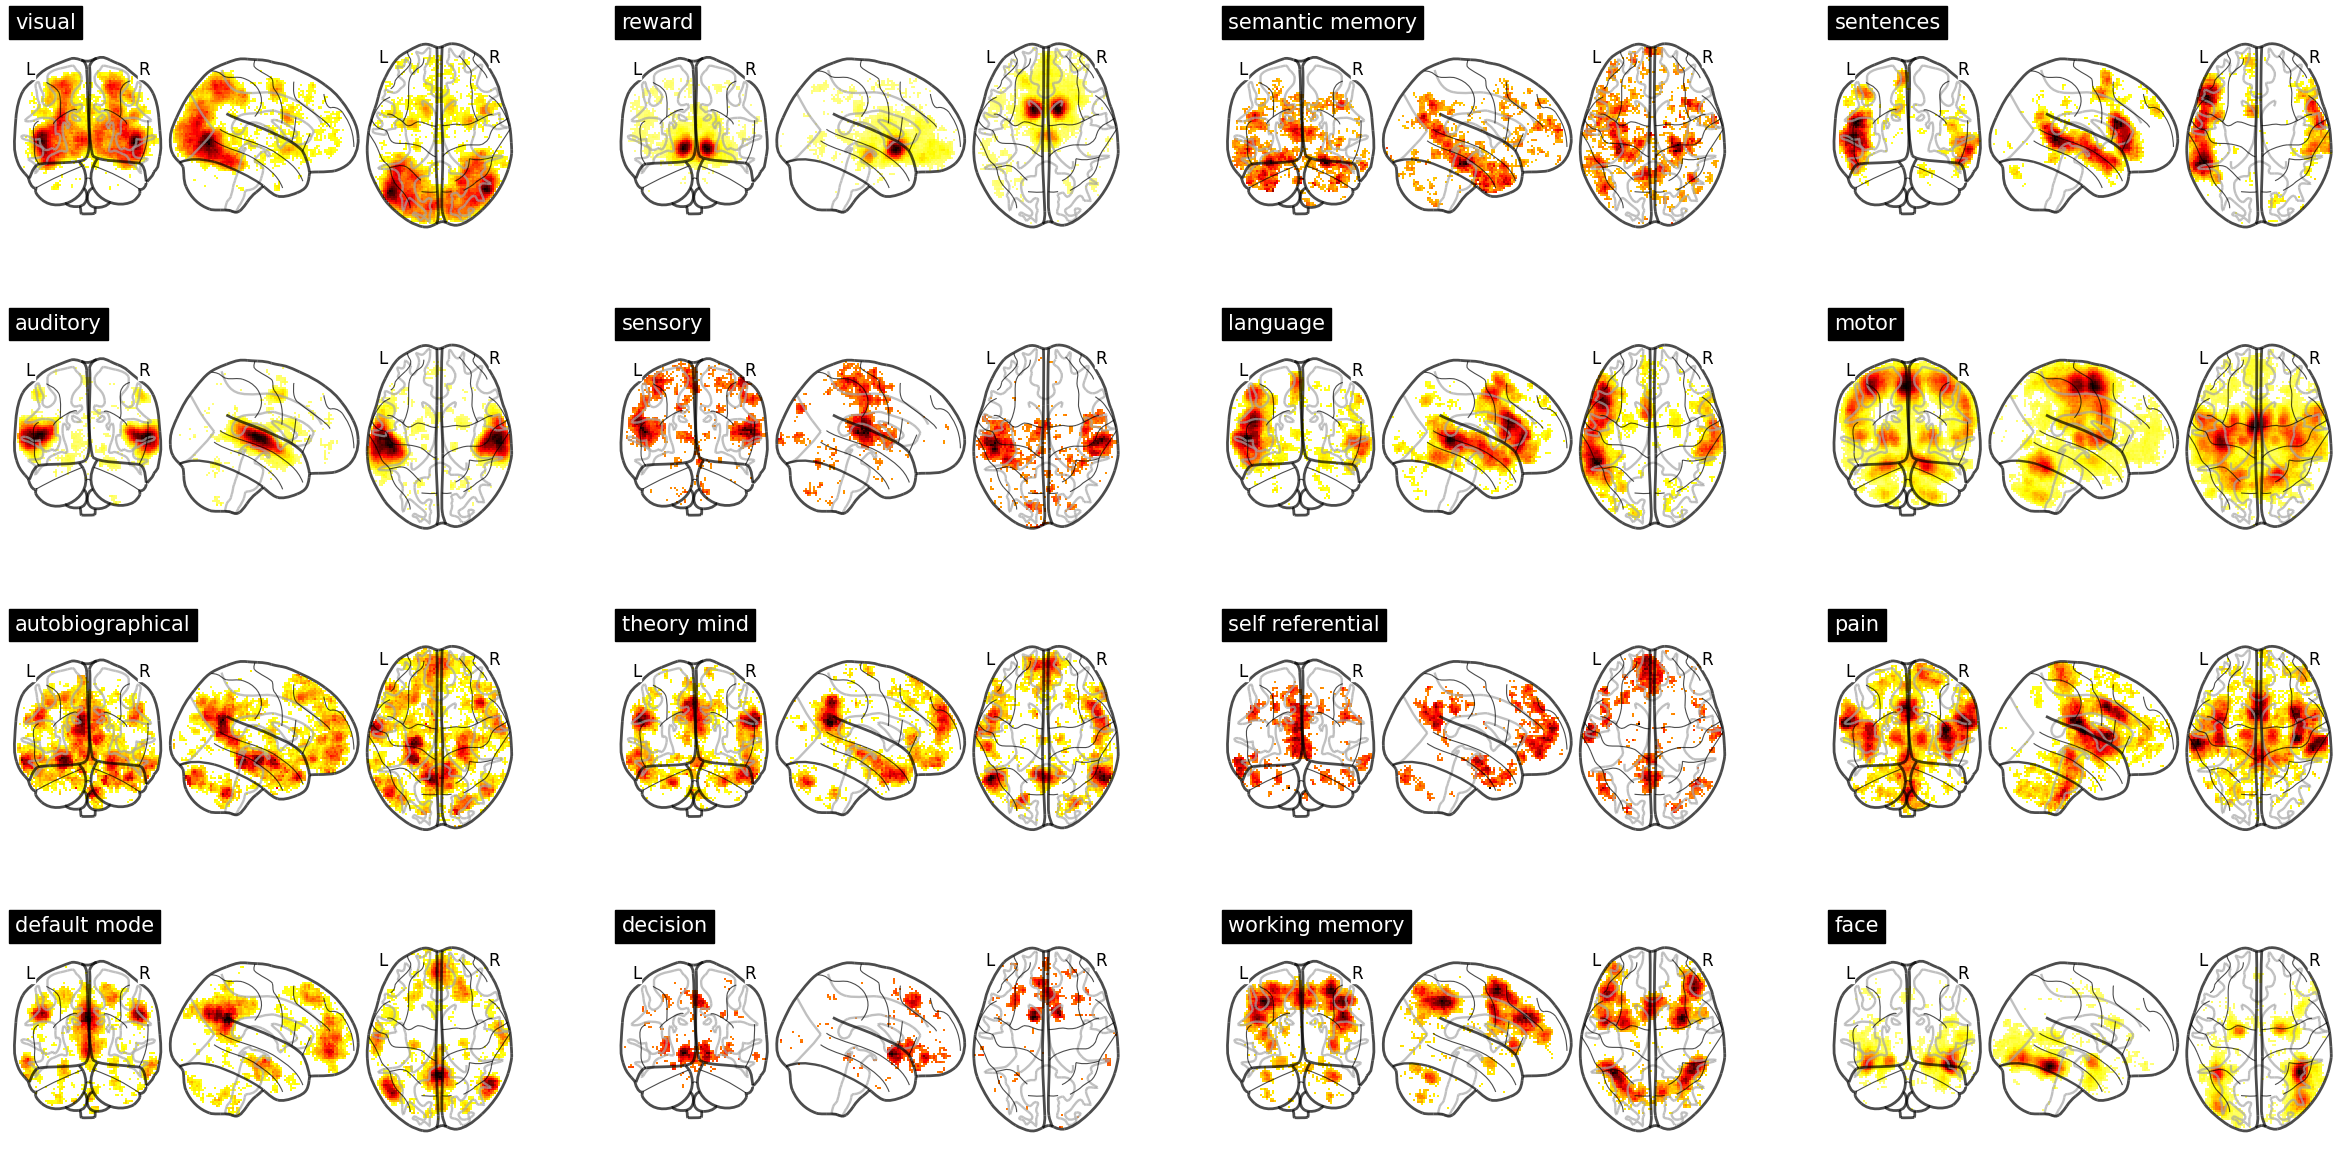

In [33]:
# load in Neurosynth maps

fig, axes = plt.subplots(4, 4, figsize=(30, 15))

maps = []
for i, f in enumerate(glob('../data_in/maps/*association-test*')):
    print(f)
    maps.append(network.State(f))
    plotting.plot_glass_brain(f, figure = fig, axes = axes.flat[i], title = f.split('/')[-1].split('_association-test')[0])
plt.show()



/home/tspisak/src/connattractor/connattractor/analysis.py:225: UserWarning: The following kwargs were not used by contour: 'color'
  


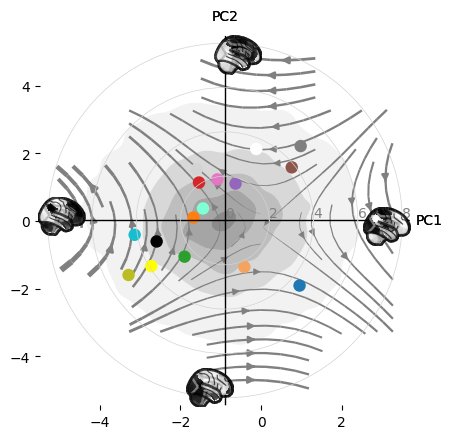

In [37]:
import matplotlib.colors as mcolors


ax = hopfield_embedding.plot(all_ts, plot_type='contourf',
                             density_bins=1000, density_sigma=20, levels=4, alpha=0.5, cmap='gray_r',
                        attractor_plot_type='scatter',
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

ax = hopfield_embedding.plot(all_ts, plot_type='stream', ax=ax,
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

colseries = list(mcolors.TABLEAU_COLORS.values()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
colors = np.array(colseries[:len(maps)])

hopfield_embedding.plot(np.tanh(np.array(maps)), alpha=1, s=80, c=colors, plot_type='scatter',
                        ax=ax.figure.add_axes(ax.get_position(), polar=True, frameon=False),
                        attractor_plot_type='glassbrain',
                        attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0),
                        regimes_contour_kwargs=dict(alpha=0, color="black")
                       )
ax.set_axisbelow(True)
ax.set_yticks([])
ax.xaxis.grid(False)

In [11]:
tmp = list(mcolors.TABLEAU_COLORS.keys()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
{f : tmp[i] for i, f in enumerate(glob('../data_in/maps/*association-test*'))}

{'../data_in/maps/visual_association-test_z_FDR_0.01.nii.gz': 'tab:blue',
 '../data_in/maps/reward_association-test_z_FDR_0.01.nii.gz': 'tab:orange',
 '../data_in/maps/semantic memory_association-test_z_FDR_0.01.nii.gz': 'tab:green',
 '../data_in/maps/sentences_association-test_z_FDR_0.01.nii.gz': 'tab:red',
 '../data_in/maps/auditory_association-test_z_FDR_0.01.nii.gz': 'tab:purple',
 '../data_in/maps/sensory_association-test_z_FDR_0.01.nii.gz': 'tab:brown',
 '../data_in/maps/language_association-test_z_FDR_0.01.nii.gz': 'tab:pink',
 '../data_in/maps/motor_association-test_z_FDR_0.01.nii.gz': 'tab:gray',
 '../data_in/maps/autobiographical_association-test_z_FDR_0.01.nii.gz': 'tab:olive',
 '../data_in/maps/theory mind_association-test_z_FDR_0.01.nii.gz': 'tab:cyan',
 '../data_in/maps/self referential_association-test_z_FDR_0.01.nii.gz': 'black',
 '../data_in/maps/pain_association-test_z_FDR_0.01.nii.gz': 'white',
 '../data_in/maps/default mode_association-test_z_FDR_0.01.nii.gz': 'yell

# todo:
- map states with low noise and high n, but without attractor calculation
- do the attractor calulcation for a random sample during embedding calculation
- make the attractor model based on that
- plot regimes non linearly (with heatmap?) rectangular grid, bigger than view, then set limits
